In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from si_prefix import si_format

# Overview #

## TODO##

 1. Implement host Python class API to wrap DMA ADC scanning mechanism
    described in [this notebook][1].
 2. Implement device C++ class API to wrap DMA ADC scanning mechanism
    described in [this notebook][1].

[1]: Example%20-%20Periodic%20multi-channel%20ADC%20multiple%20samples%20using%20DMA.ipynb

# Device

### Connect to device

In [36]:
# df_adc_configs.to_hdf('adc_configs.h5', '/adc_configs', data_columns=True,
#                       format='t', complib='zlib', complevel=5)

In [26]:
def get_adc_configs(F_BUS=48e6, ADC_CLK=22e6):
    '''
    Return `pandas.DataFrame` containing one ADC configuration per row.
    
    The conversion time is calculated according to the "ConversionTime"
    equation (see 31.4.5.5/681) in `K20P64M72SF1RM` manual.
    
    **TODO** The conversion times calculated in this function seem to
    differ from those calculated by the Kinetis ADC conversion time
    calculator.  For now, we assume that they are close enough for
    practical use, but there might be some edge cases where
    inappropriate ADC settings may be chosen as a result.
    '''
    # df_adc_configs = pd.read_msgpack('adc_configs.msg')
    df_adc_configs = pd.read_hdf('adc_configs.h5')
    
    df_adc_configs = (df_adc_configs
                      .loc[(df_adc_configs['CFG2[ADACKEN]'] == 0) &
                           (df_adc_configs['CFG1[ADICLK]'] == 1)])
    df_adc_configs.insert(3, 'CFG1[ADIV]', 0)
    df_adc_configs['ADC_CLK'] = ADC_CLK
    
    # Maximum ADC clock for 16-bit conversion is 11MHz.
    df_adc_configs.loc[(df_adc_configs['Bit-width'] >= 16) &
                       (df_adc_configs['ADC_CLK'] > 11e6),
                       'ADC_CLK'] = 11e6
    # If the ADC clock is 8MHz or higher, ADHSC (high-speed clock) bit
    # must be set.
    df_adc_configs.loc[df_adc_configs.ADC_CLK >= 8e6, 'CFG2[ADHSC]'] = 1

    conversion_time = (df_adc_configs['bus clock'] / F_BUS +
                       df_adc_configs.extra_us * 1e-6 +
                       1 / df_adc_configs.ADC_CLK
                       * (df_adc_configs.ADCK
                          + df_adc_configs.AverageNum
                          * (df_adc_configs.ADCK_bct +
                             df_adc_configs.ADCK_lst_adder +
                             df_adc_configs.ADCK_hsc_adder)))
    df_adc_configs['conversion_time'] = conversion_time
    df_adc_configs['conversion_rate'] = 1 / conversion_time
    return df_adc_configs.reset_index(drop=True).drop_duplicates().sort_values('conversion_time')

In [27]:
import pandas as pd

# pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)
# get_adc_configs()['conversion_rate']

In [33]:
import numpy as np
import pandas as pd

import arduino_helpers.hardware.teensy as teensy
from teensy_minimal_rpc.adc_sampler import AdcSampler
from teensy_minimal_rpc import SerialProxy
import teensy_minimal_rpc.ADC as ADC


ADC_CONFIGS = get_adc_configs()

# Disconnect from existing proxy (if available)
try:
#    del adc_sampler
    del proxy
except NameError:
    pass

proxy = SerialProxy()
proxy.pin_mode(teensy.LED_BUILTIN, 1)
proxy.free_all()

# Set ADC parameters
# resolution = 12
# proxy.setAveraging(0, teensy.ADC_0)
# proxy.setResolution(resolution, teensy.ADC_0)
# proxy.setConversionSpeed(teensy.ADC_VERY_HIGH_SPEED, teensy.ADC_0)
# proxy.setSamplingSpeed(teensy.ADC_VERY_HIGH_SPEED, teensy.ADC_0)
# proxy.update_adc_registers(
#     teensy.ADC_0,
#     ADC.Registers(CFG2=ADC.R_CFG2(MUXSEL=ADC.R_CFG2.B)))
# proxy.setReference(teensy.ADC_REF_1V2, teensy.ADC_0)

# channels = ['PGA0']
# 
# adc_sampler = AdcSampler(proxy, channels, 20)
# adc_sampler = None

In [34]:
def analog_reads(proxy, adc_channel, sample_count, resolution=None,
                 average_count=1, sampling_rate_hz=None,
                 differential=False, gain_power=0, adc_num=teensy.ADC_0):
    # Select ADC settings to achieve maximum conversion rate for
    # specified resolution, mode (i.e., single-ended or differential),
    # and number of samples to average per conversion (i.e., average
    # count).
    bit_width = resolution
    if 'PGA' in adc_channel:
        differential = True
    if differential:
        if resolution < 16 and not (resolution & 0x01):
            # An even number of bits was specified for resolution in differential mode.
            # However, bit-widths are actually increased by one bit, where the additional
            # bit indicates the sign of the result.
            bit_width += 1
    elif gain_power > 0:
        raise ValueError('Programmable gain amplification is only valid in '
                         'differential mode.')
    mode = 'differential' if differential else 'single-ended' 
    query = ((ADC_CONFIGS.AverageNum == average_count)
             & (ADC_CONFIGS.Mode == mode))
    if resolution is not None:
        query &= (ADC_CONFIGS['Bit-width'] == bit_width)
    if sampling_rate_hz is not None:
        query &= (ADC_CONFIGS.conversion_rate >= sampling_rate_hz)
    matching_settings = ADC_CONFIGS.loc[query]
    min_match_index = matching_settings['conversion_rate'].argmin()
    adc_settings = matching_settings.loc[min_match_index].copy()
    
    if differential:
        proxy.setReference(teensy.ADC_REF_1V2, adc_num)
        reference_V = 1.2
    else:
        proxy.setReference(teensy.ADC_REF_3V3, adc_num)
        reference_V = 3.3
    assert(gain_power >= 0 and gain_power < 8)
    adc_settings['gain_power'] = int(gain_power)
        
    adc_registers = ADC.Registers(CFG2=ADC.R_CFG2(MUXSEL=ADC.R_CFG2.B,
                                                  ADACKEN=
                                                  int(adc_settings['CFG2[ADACKEN]']),
                                                  ADLSTS=
                                                  int(adc_settings['CFG2[ADLSTS]']),
                                                  ADHSC=
                                                  int(adc_settings['CFG2[ADHSC]'])),
                                  CFG1=ADC.R_CFG1(ADLSMP=
                                                  int(adc_settings['CFG1[ADLSMP]']),
                                                  ADICLK=
                                                  int(adc_settings['CFG1[ADICLK]']),
                                                  ADIV=
                                                  int(adc_settings['CFG1[ADIV]'])))
    if 'PGA' in adc_channel:
        adc_registers.PGA.PGAG = adc_settings.gain_power
        adc_registers.PGA.PGAEN = True
            
    proxy.update_adc_registers(adc_num, adc_registers)
    
    # Apply ADC settings.
    proxy.setAveraging(average_count, adc_num)
    proxy.setResolution(resolution, adc_num)
    
    # Create `AdcSampler` for:
    #  - The specified channel.
    #  - The specified sample count.
    channels = [adc_channel]

    if sampling_rate_hz is None:
        sampling_rate_hz = int(.9 * adc_settings.conversion_rate) & 0xFFFFFFFE
        
    adc_sampler = AdcSampler(proxy, channels, sample_count)
    adc_sampler.reset()
    adc_sampler.start_read(sampling_rate_hz)
    df_adc_results = adc_sampler.get_results().astype('int16')
    df_volts = reference_V * (df_adc_results /
                              (1 << (resolution +
                                     adc_settings.gain_power)))
    return sampling_rate_hz, adc_settings, df_volts, df_adc_results

In [35]:
def rms(x, mean_=None):
    if mean_ is None:
        mean_ = x.mean()
    return np.sqrt(((x - mean_) ** 2).mean())

frames = []

for resolution in 8, 10, 12:
    for average_count in (1, 4, 8, 16, 32):
        for i in xrange(5):
            proxy.free_all()
            try:
                (sampling_rate_hz, adc_settings,
                 df_volts_i, df_adc_results) = analog_reads(proxy, 'PGA0', 80, 
                                                            resolution=resolution,
                                                            average_count=
                                                            average_count,
                                                            sampling_rate_hz=100e3,
                                                            gain_power=0)
            except:
                print ('warning: no config found for %s' %
                       [resolution, average_count, i])
                continue
            df_volts_i.insert(0, 'resolution', resolution)
            df_volts_i.insert(1, 'average_count', average_count)
            df_volts_i.insert(2, 'window_i', i)
            frames.append(df_volts_i)

df_volts = pd.concat(frames)
df_volts_pp = df_volts.groupby(['resolution',
                                'average_count',
                                'window_i']).agg(rms) * 2 * np.sqrt(2)
rms_error = (df_volts_pp.groupby(axis=0, level=[0, 1])
             .agg(lambda s: rms(s, .5))['PGA0'])

# print sampling_rate_hz, adc_settings.conversion_rate, adc_settings.gain_power
# axis = df_volts.plot(ylim=(-1.2 / (1 << adc_settings.gain_power),
#                            1.2 / (1 << adc_settings.gain_power)))
# print 'Vpp(sin): %sV' % si_format(rms(df_volts.PGA0) * 2 * np.sqrt(2))
# axis2 = axis.twinx()
# df_adc_results.plot(ylim=(-1 << (resolution), 1 << (resolution)),
#                     style='x', ax=axis2)

In [8]:
rms_error

resolution  average_count
8           1                0.488655
            4                0.493541
10          1                0.488079
            4                0.494818
12          1                0.488659
            4                0.494976
Name: PGA0, dtype: float64

In [94]:
df_rms = df_results.groupby('window_i').agg(rms) * 2 * np.sqrt(2)
rms(df_rms, .5)

PGA0    0.000811
dtype: float64

In [56]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [60]:
test_read()

In [ ]:
config = analog_reads(proxy, 'PGA0', 10, resolution=12, average_count=4,
                      sampling_rate_hz=200e3)
config

In [ ]:
data = ADC_CONFIGS['conversion_rate'].reset_index(drop=True)
data.plot(style='x')

In [ ]:
from arduino_rpc.protobuf import resolve_field_values

In [ ]:
# proxy.update_adc_registers(teensy.ADC_0, ADC.Registers(SC1A=ADC.R_SC1(ADCH=0, DIFF=True)))
# proxy.update_adc_registers(teensy.ADC_0, ADC.Registers(PGA=ADC.R_PGA(PGAG=ADC.R_PGA._1,
#                                                                      PGAEN=True)))
df_ADC = (resolve_field_values(ADC.Registers
                               .FromString(proxy.read_adc_registers(teensy.ADC_0)
                                           .tostring()))[['full_name', 'value']])
# df_ADC.set_index('full_name')[['RA', 'SC1A.COCO']]
df_ADC.loc[['PGA']]

In [ ]:
ADC0_PGA = 0x4003B050  # ADC Programmable Gain Amplifier
hex(proxy.mem_cpy_device_to_host(ADC0_PGA, 4)[2])

In [ ]:
channels = ['PGA0']
adc_sampler = AdcSampler(proxy, channels, 20)

gain_power = 5
resolution = 12
proxy.update_adc_registers(teensy.ADC_0,
                           ADC.Registers(PGA=ADC.R_PGA(PGAG=gain_power,
                                                       PGAEN=True)))
adc_sampler.reset()
adc_sampler.start_read(100e3)

print 'Samples by channel:'
df_adc_results = adc_sampler.get_results().astype('int16')
df_volts = df_adc_results / (1 << (resolution + gain_power)) * 1.2
ylim = tuple(df_adc_results.describe().loc[['min', 'max']].PGA0.values)
# df_adc_results.plot(ylim=(0, 1 << (resolution)))
df_volts.plot(ylim=(-1.2 / (1 << gain_power), 1.2 / (1 << gain_power)))
print 'Vpp(sin): %sV' % si_format(rms(df_volts.PGA0) * 2 * np.sqrt(2))
df_volts.T

In [ ]:
print df_volts.describe().loc[['min', 'max']].diff()
df_volts.describe()

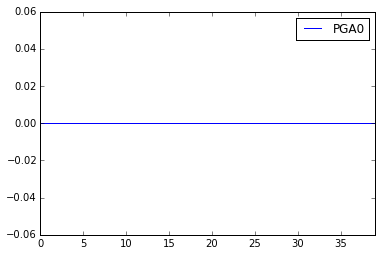

In [13]:
def rms(x):
    return np.sqrt(((x - x.mean()) ** 2).mean())

x = df_volts
((x - x.mean()) ** 2).plot()

In [ ]:
proxy.






















